<a href="https://colab.research.google.com/github/jryuuu22/basketball-eclipse-project/blob/main/Basketball_Eclipse_Analytics_Project_Free_Throw_Pressure_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basketball Eclipse Analytics Project: Free Throw Pressure Modeling

**Authors:** Jay Wu and Alay Nawab

Goals
- Clean dataset and produce easy to understand EDA
- Engineer pressure and player-skill features
- Compare 3 models with Optuna: Logistic Regression, Random Forest, XGBoost
- Optimize for PR-AUC and pick best model
- Evaluate on chronological test split
- Produce clear visualizations and Save Artifacts
- Provide a clean `ft_pressure_final.py` module with `FTPressurePredictor` for deployment

### Set Up and Imports

In [ ]:
# Install libraries and import common packages
!pip install optuna xgboost kagglehub -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import optuna
import pickle
from  typing import List, Dict, Union, Optional, Any

import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    brier_score_loss,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_curve,
    auc,
)
sns.set(style="whitegrid")

Load Module and Data

In [ ]:
#  Write ft_pressure_final.py
module_code = r"""
#Free Throw Pressure Modeling – Final Module

#Functions:
#- prepare_ft_dataset_from_df: build modeling dataframe from raw play-by-play.
#- train_and_save_model: chronological split, scale, train XGB/RF, save artifacts.
#- FTPressurePredictor: load artifacts and run single/batch predictions + explanations.
#- evaluate_model: compute accuracy, PR-AUC, ROC-AUC, Brier and show confusion matrix.

import re
import pickle
from typing import List, Dict, Union, Optional, Any

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    brier_score_loss,
    roc_curve,
    precision_recall_curve,
    auc,
    confusion_matrix,
)

from xgboost import XGBClassifier


# -----------------------------
# Global feature configuration
# -----------------------------

FEATURE_COLS: List[str] = [
    "season_FT_pct",
    "overall_ft_pct",
    "clutch_ft_pct",
    "clutch_factor",
    "career_attempts_so_far",
    "period",
    "seconds_remaining",
    "is_clutch",
    "close_game",
    "late_game",
    "pressure_score",
    "point_differential",
]

# Best Random Forest params (from Optuna / tuning)
BEST_RF_PARAMS: Dict[str, Any] = {
    "n_estimators": 188,
    "max_depth": 4,
    "min_samples_split": 6,
    "min_samples_leaf": 11,
    "max_features": "log2",
    "random_state": 42,
    "n_jobs": -1,
    "oob_score": True,
}

# Best XGBoost params (from Optuna/tuning)
BEST_XGB_PARAMS: Dict[str, Any] = {
    "n_estimators": 409,
    "max_depth": 2,
    "learning_rate": 0.032341352182250115,
    "subsample": 0.9,
    "colsample_bytree": 0.6724954243953047,
    "min_child_weight": 1.0,
    "reg_alpha": 0.0,
    "reg_lambda": 1.0,
    "eval_metric": "logloss",
    "n_jobs": -1,
    "random_state": 42,
}


# -----------------------------
# Helper parsing functions
# -----------------------------

def _extract_player_name(description: Any) -> Optional[str]:
    #Extract player name from a free-throw event description.
    if pd.isna(description):
        return None
    match = re.search(r"^(?:MISS\s+)?([A-Za-z\.\s]+?)\s+Free Throw", str(description))
    return match.group(1).strip() if match else None


def _time_to_seconds(time_str: Any) -> Optional[int]:
    #Convert mm:ss string to total seconds remaining in the period.
    if pd.isna(time_str):
        return None
    try:
        mm, ss = str(time_str).split(":")
        return int(mm) * 60 + int(ss)
    except Exception:
        return None


def _parse_score_diff(score_str: Any) -> Optional[int]:
    #Return absolute score differential from 'home - away' string.
    if pd.isna(score_str):
        return None
    try:
        home, away = score_str.split(" - ")
        return abs(int(home) - int(away))
    except Exception:
        return None


# -----------------------------
# Dataset preparation
# -----------------------------

def prepare_ft_dataset_from_df(input_df: pd.DataFrame) -> pd.DataFrame:

    #From raw play-by-play, build a modeling dataframe with engineered pressure and player-skill features for free throws.

    df = input_df.copy()

    # Keep only free throw events
    keyword = "Free Throw"
    df = df[
        df[["homedescription", "visitordescription"]]
        .apply(lambda x: x.astype(str).str.contains(keyword, case=False, na=False))
        .any(axis=1)
    ]

    # Drop columns not needed for modeling
    df = df.drop(
        columns=[
            "neutraldescription",
            "video_available_flag",
            "person1type",
            "player1_team_nickname",
            "player1_team_abbreviation",
            "player1_id",
            "player1_name",
            "player1_team_city",
            "player1_team_id",
            "person2type",
            "player2_team_nickname",
            "player2_team_abbreviation",
            "player2_id",
            "player2_name",
            "player2_team_city",
            "player2_team_id",
            "person3type",
            "player3_team_nickname",
            "player3_team_abbreviation",
            "player3_id",
            "player3_name",
            "player3_team_city",
            "player3_team_id",
        ],
        errors="ignore",
    )

    # Consolidate home/visitor descriptions into a single FT event description
    nan_idx = df[df["homedescription"].isna()].index
    df.loc[nan_idx, "homedescription"] = df.loc[nan_idx, "visitordescription"]
    df = df.drop(columns=["visitordescription"], errors="ignore")
    df = df.rename(columns={"homedescription": "FT_Event"})

    # Target: made vs missed FT
    missed_mask = df["FT_Event"].str.contains("MISS", case=False, na=False)
    df["FT_made"] = (~missed_mask).astype(int)

    # Ensure score is forward-filled within each game
    df = df.sort_values(["game_id", "period", "eventnum"])
    df["score"] = df.groupby("game_id")["score"].ffill()
    df = df.dropna(subset=["score"])

    # Parse score into home/away and margin
    score_clean = df["score"].str.replace(" ", "")
    df["home_score"] = score_clean.str.split("-").str[0].astype(int)
    df["away_score"] = score_clean.str.split("-").str[1].astype(int)
    df["scoremargin"] = df["home_score"] - df["away_score"]

    # Player and time features
    df["player_name"] = df["FT_Event"].apply(_extract_player_name)
    df["seconds_remaining"] = df["pctimestring"].apply(_time_to_seconds)

    # Clutch definition: last 5 minutes of 4th+ period
    df["is_clutch"] = (
        (df["period"] >= 4) & (df["seconds_remaining"] <= 300)
    ).astype(int)
    df["point_differential"] = df["score"].apply(_parse_score_diff)
    df["high_pressure"] = (
        (df["is_clutch"] == 1) & (df["point_differential"] <= 5)
    ).astype(int)

    # Season-level FT% for current season window
    season_ft = (
        df.groupby("player_name")["FT_made"]
        .mean()
        .reset_index()
        .rename(columns={"FT_made": "season_FT_pct"})
    )
    df = df.merge(season_ft, on="player_name", how="left")

    # Player aggregate stats across all rows
    player_stats = (
        df.groupby("player_name")
        .agg(
            {
                "FT_made": ["sum", "count", "mean"],
                "is_clutch": "sum",
                "high_pressure": "sum",
            }
        )
        .reset_index()
    )
    player_stats.columns = [
        "player_name",
        "ft_made_total",
        "ft_attempts",
        "overall_ft_pct",
        "clutch_attempts",
        "high_pressure_attempts",
    ]

    # Clutch FT% and high-pressure FT%
    clutch_stats = (
        df[df["is_clutch"] == 1]
        .groupby("player_name")["FT_made"]
        .mean()
        .reset_index()
        .rename(columns={"FT_made": "clutch_ft_pct"})
    )
    high_pressure_stats = (
        df[df["high_pressure"] == 1]
        .groupby("player_name")["FT_made"]
        .mean()
        .reset_index()
        .rename(columns={"FT_made": "high_pressure_ft_pct"})
    )

    player_stats = player_stats.merge(clutch_stats, on="player_name", how="left")
    player_stats = player_stats.merge(high_pressure_stats, on="player_name", how="left")
    player_stats["clutch_factor"] = (
        player_stats["clutch_ft_pct"] - player_stats["overall_ft_pct"]
    )

    df = df.merge(
        player_stats[
            ["player_name", "overall_ft_pct", "clutch_ft_pct", "clutch_factor"]
        ],
        on="player_name",
        how="left",
    )

    # Pressure-related flags
    df["close_game"] = (df["point_differential"] <= 3).astype(int)
    df["late_game"] = (df["period"] >= 4).astype(int)
    df["pressure_score"] = (
        df["is_clutch"].astype(int)
        + df["close_game"].astype(int)
        + (df["seconds_remaining"] <= 120).astype(int)
    )

    # Career attempts so far (approx)
    career_attempts = df.groupby("player_name").size().to_dict()
    df["career_attempts_so_far"] = df["player_name"].map(career_attempts)

    # Final modeling dataframe
    model_df = df[FEATURE_COLS + ["FT_made", "game_id"]].copy()
    model_df = model_df.dropna(subset=["FT_made", "game_id"])

    return model_df


# -----------------------------
# Training and saving artifacts
# -----------------------------

def train_and_save_model(
    play_by_play_path: str,
    nrows: Optional[int] = None,
    test_size: float = 0.2,
    model_type: str = "xgb",  # "xgb" or "rf"
    model_path: str = "final_xgb.pkl",
    imputer_path: str = "imputer.pkl",
    scaler_path: str = "scaler.pkl",
    x_train_path: str = "X_train.csv",
    x_test_path: str = "X_test.csv",
    y_train_path: str = "y_train.csv",
    y_test_path: str = "y_test.csv",
) -> Dict[str, float]:

    #Train a free-throw pressure model with chronological split, scale features,
    #evaluate on test set, and save model + preprocessing + CSV splits.

    raw_df = pd.read_csv(play_by_play_path, nrows=nrows)
    model_df = prepare_ft_dataset_from_df(raw_df)

    X = model_df[FEATURE_COLS].copy()
    y = model_df["FT_made"].astype(int).copy()
    game_ids = model_df["game_id"].unique()

    # Chronological split by game_id
    train_games, test_games = train_test_split(
        game_ids, test_size=test_size, shuffle=False
    )
    train_mask = model_df["game_id"].isin(train_games)
    test_mask = model_df["game_id"].isin(test_games)

    X_train_raw = X[train_mask].copy()
    X_test_raw = X[test_mask].copy()
    y_train = y[train_mask].copy()
    y_test = y[test_mask].copy()

    # Save preprocessed splits (raw feature space, not imputed/scaled)
    X_train_raw.to_csv(x_train_path, index=False)
    X_test_raw.to_csv(x_test_path, index=False)
    y_train.to_csv(y_train_path, index=False)
    y_test.to_csv(y_test_path, index=False)

    # Impute and scale
    imputer = SimpleImputer(strategy="median")
    X_train_imp = pd.DataFrame(
        imputer.fit_transform(X_train_raw),
        columns=FEATURE_COLS,
        index=X_train_raw.index,
    )
    X_test_imp = pd.DataFrame(
        imputer.transform(X_test_raw),
        columns=FEATURE_COLS,
        index=X_test_raw.index,
    )

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_imp),
        columns=FEATURE_COLS,
        index=X_train_imp.index,
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test_imp),
        columns=FEATURE_COLS,
        index=X_test_imp.index,
    )

    # Choose model
    if model_type.lower() == "rf":
        model = RandomForestClassifier(**BEST_RF_PARAMS)
    elif model_type.lower() == "xgb":
        model = XGBClassifier(**BEST_XGB_PARAMS)
    else:
       raise ValueError("model_type must be 'xgb' or 'rf'.")

    model.fit(X_train_scaled, y_train)

    # Test-set probabilities and predictions
    y_proba_test = model.predict_proba(X_test_scaled)[:, 1]
    y_pred_test = (y_proba_test >= 0.5).astype(int)

    # Core metrics
    acc = accuracy_score(y_test, y_pred_test)
    pr_auc = average_precision_score(y_test, y_proba_test)
    brier = brier_score_loss(y_test, y_proba_test)

    # Save artifacts
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    with open(imputer_path, "wb") as f:
        pickle.dump(imputer, f)
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)

    results = {
        "accuracy": float(acc),
        "pr_auc": float(pr_auc),
        "brier": float(brier),
    }

    # Optional: RF only – add OOB score if available
    if hasattr(model, "oob_score_"):
        results["oob_score"] = float(model.oob_score_)

    return results


# -----------------------------
# Prediction + explanations
# -----------------------------

class PredictionExplanation:
    #Container for single-shot prediction with simple factor breakdown.

    def __init__(
        self,
        prob_make: float,
        predicted_label: int,
        top_factors: List[Dict[str, Any]],
    ) -> None:
        self.prob_make = prob_make
        self.predicted_label = predicted_label
        self.top_factors = top_factors


class FTPressurePredictor:

    #Load trained model, imputer, scaler and provide:
    #- predict_proba for single/batch inputs
    #- predict for hard labels
    #- predict_single_with_explanation for quick interpretability
    #- feature_importances for global importance


    def __init__(
        self,
        model_path: str = "final_xgb.pkl",
        imputer_path: str = "imputer.pkl",
        scaler_path: str = "scaler.pkl",
        feature_cols: Optional[List[str]] = None,
    ) -> None:
        self.feature_cols = feature_cols or FEATURE_COLS

        with open(model_path, "rb") as f:
            self.model = pickle.load(f)
        with open(imputer_path, "rb") as f:
            self.imputer = pickle.load(f)
        with open(scaler_path, "rb") as f:
            self.scaler = pickle.load(f)

        if not hasattr(self.model, "feature_importances_"):
            raise ValueError(
                "Loaded model does not expose feature_importances_. "
                "Use a tree-based model such as RandomForest or XGBoost."
            )

        if len(self.model.feature_importances_) != len(self.feature_cols):
            raise ValueError(
                "Feature length mismatch between model and feature_cols."
            )

    # ---------- internal helpers ----------

    def _to_dataframe(
        self, X: Union[Dict[str, float], pd.Series, pd.DataFrame]
    ) -> pd.DataFrame:
        #Convert dict/Series/DataFrame into a DataFrame with correct columns.
        if isinstance(X, dict):
            df = pd.DataFrame([X])
        elif isinstance(X, pd.Series):
            df = X.to_frame().T
        elif isinstance(X, pd.DataFrame):
            df = X.copy()
        else:
            raise TypeError("X must be dict, pandas Series, or pandas DataFrame.")

        missing = [c for c in self.feature_cols if c not in df.columns]
        if missing:
            raise ValueError(f"Missing required feature(s): {missing}")

        df = df[self.feature_cols]
        df = df.apply(pd.to_numeric, errors="coerce")
        return df

    def _prepare_for_model(self, X_raw: pd.DataFrame) -> pd.DataFrame:
        #Apply stored imputer + scaler to raw feature DataFrame.
        X_imp = pd.DataFrame(
            self.imputer.transform(X_raw),
            columns=self.feature_cols,
            index=X_raw.index,
        )
        X_scaled = pd.DataFrame(
            self.scaler.transform(X_imp),
            columns=self.feature_cols,
            index=X_imp.index,
        )
        return X_scaled

    # ---------- public API ----------

    def predict_proba(
        self, X: Union[Dict[str, float], pd.Series, pd.DataFrame]
    ) -> np.ndarray:
        #Return probability of make for each row.
        df_raw = self._to_dataframe(X)
        X_scaled = self._prepare_for_model(df_raw)
        probs = self.model.predict_proba(X_scaled)[:, 1]
        return probs

    def predict(
        self,
        X: Union[Dict[str, float], pd.Series, pd.DataFrame],
        threshold: float = 0.5,
    ) -> np.ndarray:
        #Return binary predictions using a probability threshold.
        probs = self.predict_proba(X)
        return (probs >= threshold).astype(int)

    def predict_single_with_explanation(
        self,
        X: Union[Dict[str, float], pd.Series],
        threshold: float = 0.5,
        top_k: int = 3,
    ) -> PredictionExplanation:

        #Predict a single free throw outcome with a simple explanation that highlights the top contributing features (based on scaled value * importance).

        df_raw = self._to_dataframe(X)
        if len(df_raw) != 1:
            raise ValueError("predict_single_with_explanation expects exactly one row.")

        X_scaled = self._prepare_for_model(df_raw)
        prob_make = float(self.predict_proba(df_raw)[0])
        predicted_label = int(prob_make >= threshold)

        fi = np.array(self.model.feature_importances_, dtype=float)
        fi = np.maximum(fi, 0.0)

        row_vals = X_scaled.iloc[0].values.astype(float)
        contrib_scores = np.abs(row_vals) * fi
        total = contrib_scores.sum()
        if total <= 0:
            contrib_scores = fi
            total = contrib_scores.sum() if contrib_scores.sum() > 0 else 1.0

        contrib_pct = (contrib_scores / total) * 100.0

        contrib_df = (
            pd.DataFrame(
                {
                    "feature": self.feature_cols,
                    "value": row_vals,
                    "contribution_pct": contrib_pct,
                }
            )
            .sort_values("contribution_pct", ascending=False)
            .reset_index(drop=True)
        )

        top = contrib_df.head(top_k)
        top_factors = [
            {
                "feature": r["feature"],
                "value": float(r["value"]),
                "contribution_pct": float(r["contribution_pct"]),
            }
            for _, r in top.iterrows()
        ]

        return PredictionExplanation(
            prob_make=prob_make,
            predicted_label=predicted_label,
            top_factors=top_factors,
        )

    def feature_importances(self) -> pd.DataFrame:
        #Return global feature importances and percentage share.
        fi = np.array(self.model.feature_importances_, dtype=float)
        total = fi.sum() if fi.sum() > 0 else 1.0
        pct = (fi / total) * 100.0
        return (
            pd.DataFrame(
                {"feature": self.feature_cols, "importance": fi, "importance_pct": pct}
            )
            .sort_values("importance", ascending=False)
            .reset_index(drop=True)
        )

    def get_oob_score(self) -> Optional[float]:
        #Return OOB score if model exposes it (RF only).
        return getattr(self.model, "oob_score_", None)


# -----------------------------
# Evaluation helper
# -----------------------------

def evaluate_model(
    predictor: FTPressurePredictor,
    X_test: pd.DataFrame,
    y_test: Union[pd.Series, np.ndarray],
    threshold: float = 0.5,
) -> Dict[str, float]:

    #Evaluate a trained FTPressurePredictor on a test set and print metrics:
    #Accuracy, PR-AUC, ROC-AUC, Brier, and confusion matrix.

    if isinstance(y_test, pd.Series):
        y = y_test.values
    else:
        y = y_test

    probs = predictor.predict_proba(X_test)
    preds = (probs >= threshold).astype(int)

    acc = accuracy_score(y, preds)
    pr_auc = average_precision_score(y, probs)
    brier = brier_score_loss(y, probs)
    fpr, tpr, _ = roc_curve(y, probs)
    roc_auc_val = auc(fpr, tpr)
    cm = confusion_matrix(y, preds)

    print("=== Test Set Performance ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"PR-AUC   : {pr_auc:.4f}")
    print(f"ROC-AUC  : {roc_auc_val:.4f}")
    print(f"Brier    : {brier:.4f}")
    print("Confusion matrix [rows=true, cols=pred]:")
    print(cm)

    return {
        "accuracy": float(acc),
        "pr_auc": float(pr_auc),
        "roc_auc": float(roc_auc_val),
        "brier": float(brier),
    }
"""

with open("ft_pressure_final.py", "w") as f:
    f.write(module_code)
print("Module written. Files:", os.listdir())

Module written. Files: ['.config', 'ft_pressure_final.py', 'X_train.csv', 'imputer.pkl', 'y_train.csv', 'final_xgb.pkl', 'X_test.csv', 'scaler.pkl', 'final_model.pkl', 'y_test.csv', '__pycache__', 'sample_data']


In [ ]:
# Load reusable module and raw Kaggle data
import importlib
import ft_pressure_final
importlib.reload(ft_pressure_final)

from ft_pressure_final import (
    prepare_ft_dataset_from_df,
    train_and_save_model,
    FTPressurePredictor,
    evaluate_model,
    FEATURE_COLS,
)

#Download Dataset
basketball = kagglehub.dataset_download("wyattowalsh/basketball")
csv_path = f"{basketball}/csv"
play_by_play_path = f"{csv_path}/play_by_play.csv"

print("Using:", play_by_play_path)
df_raw = pd.read_csv(play_by_play_path, nrows=100000)
df_raw.head()

Using Colab cache for faster access to the 'basketball' dataset.
Using: /kaggle/input/basketball/csv/play_by_play.csv


,game_id,eventnum,eventmsgtype,eventmsgactiontype,period,wctimestring,pctimestring,homedescription,neutraldescription,visitordescription,...,player2_team_nickname,player2_team_abbreviation,person3type,player3_id,player3_name,player3_team_id,player3_team_city,player3_team_nickname,player3_team_abbreviation,video_available_flag
0,29600012,0,12,0,1,14:43 PM,12:00,NaN,Start of 1st Period (14:43 PM EST),NaN,...,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0
1,29600012,2,10,0,1,14:50 PM,12:00,Jump Ball O'Neal vs. Kleine: Tip to Cassell,NaN,NaN,...,Suns,PHX,5.0,208,Sam Cassell,1.610613e+09,Phoenix,Suns,PHX,0
2,29600012,3,2,1,1,14:51 PM,11:45,NaN,NaN,MISS Cassell 15' Jump Shot,...,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0
3,29600012,4,4,0,1,14:51 PM,11:43,O'Neal REBOUND (Off:0 Def:1),NaN,NaN,...,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0
4,29600012,5,2,1,1,14:51 PM,11:29,MISS Ceballos 26' 3PT Jump Shot,NaN,NaN,...,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,0


### Define Feature Columns and Helper Functions

In [ ]:
from typing import List

# Define feature list
FEATURE_COLS: List[str] = [
    "season_FT_pct",
    "overall_ft_pct",
    "clutch_ft_pct",
    "clutch_factor",
    "career_attempts_so_far",
    "period",
    "seconds_remaining",
    "is_clutch",
    "close_game",
    "late_game",
    "pressure_score",
    "point_differential",
]

Define Helpers for Feature Engineering

In [ ]:
# Build helpers used in feature engineering
def _extract_player_name(description: Any) -> Optional[str]:
    """Extract player name from FT description like 'MISS Jordan Free Throw 2 of 2'."""
    if pd.isna(description):
        return None
    match = re.search(r"^(?:MISS\s+)?([A-Za-z\.\s]+?)\s+Free Throw", str(description))
    return match.group(1).strip() if match else None


def _time_to_seconds(time_str: Any) -> Optional[int]:
    """Convert 'MM:SS' to total seconds."""
    if pd.isna(time_str):
        return None
    try:
        mm, ss = str(time_str).split(":")
        return int(mm) * 60 + int(ss)
    except Exception:
        return None


def _parse_score_diff(score_str: Any) -> Optional[int]:
    """Parse '71 - 85' → |71 - 85|."""
    if pd.isna(score_str):
        return None
    try:
        home, away = score_str.split(" - ")
        return abs(int(home) - int(away))
    except Exception:
        return None

### Preparing dataset function

In [ ]:
# Build modeling dataset from raw play-by-play dataset

def prepare_ft_dataset_from_df(input_df: pd.DataFrame) -> pd.DataFrame:
    """
    Feature-engineer a modeling DataFrame from raw play_by_play data.

    Returns
    -------
    model_df : DataFrame
        Contains FEATURE_COLS + ['FT_made', 'game_id'].
    """
    df = input_df.copy()

    # 1) Keep only free throw events
    keyword = "Free Throw"
    df = df[
        df[["homedescription", "visitordescription"]]
        .apply(lambda x: x.astype(str).str.contains(keyword, case=False, na=False))
        .any(axis=1)
    ]

    # 2) Drop many unused columns
    df = df.drop(
        columns=[
            "neutraldescription",
            "video_available_flag",
            "person1type",
            "player1_team_nickname",
            "player1_team_abbreviation",
            "player1_id",
            "player1_name",
            "player1_team_city",
            "player1_team_id",
            "person2type",
            "player2_team_nickname",
            "player2_team_abbreviation",
            "player2_id",
            "player2_name",
            "player2_team_city",
            "player2_team_id",
            "person3type",
            "player3_team_nickname",
            "player3_team_abbreviation",
            "player3_id",
            "player3_name",
            "player3_team_city",
            "player3_team_id",
        ],
        errors="ignore",
    )

    # 3) Merge home/visitor descriptions into a single FT_Event
    nan_idx = df[df["homedescription"].isna()].index
    df.loc[nan_idx, "homedescription"] = df.loc[nan_idx, "visitordescription"]
    df = df.drop(columns=["visitordescription"], errors="ignore")
    df = df.rename(columns={"homedescription": "FT_Event"})

    # 4) Target: made vs missed FT
    missed_mask = df["FT_Event"].str.contains("MISS", case=False, na=False)
    df["FT_made"] = (~missed_mask).astype(int)

    # 5) Fix score with game-wise forward fill
    df = df.sort_values(["game_id", "period", "eventnum"])
    df["score"] = df.groupby("game_id")["score"].ffill()
    df = df.dropna(subset=["score"])

    # 6) Parse score to home/away and margin
    score_clean = df["score"].str.replace(" ", "")
    df["home_score"] = score_clean.str.split("-").str[0].astype(int)
    df["away_score"] = score_clean.str.split("-").str[1].astype(int)
    df["scoremargin"] = df["home_score"] - df["away_score"]

    # 7) Player name
    df["player_name"] = df["FT_Event"].apply(_extract_player_name)

    # 8) Time and clutch flags
    df["seconds_remaining"] = df["pctimestring"].apply(_time_to_seconds)
    df["is_clutch"] = (
        (df["period"] >= 4) & (df["seconds_remaining"] <= 300)
    ).astype(int)
    df["point_differential"] = df["score"].apply(_parse_score_diff)
    df["high_pressure"] = (
        (df["is_clutch"] == 1) & (df["point_differential"] <= 5)
    ).astype(int)

    # 9) Player-level aggregates
    # Season FT% (within this dataset)
    season_ft = (
        df.groupby("player_name")["FT_made"]
        .mean()
        .reset_index()
        .rename(columns={"FT_made": "season_FT_pct"})
    )
    df = df.merge(season_ft, on="player_name", how="left")

    # Overall FT%, clutch/high-pressure attempts, clutch FT%
    player_stats = (
        df.groupby("player_name")
        .agg(
            {
                "FT_made": ["sum", "count", "mean"],
                "is_clutch": "sum",
                "high_pressure": "sum",
            }
        )
        .reset_index()
    )
    player_stats.columns = [
        "player_name",
        "ft_made_total",
        "ft_attempts",
        "overall_ft_pct",
        "clutch_attempts",
        "high_pressure_attempts",
    ]

    clutch_stats = (
        df[df["is_clutch"] == 1]
        .groupby("player_name")["FT_made"]
        .mean()
        .reset_index()
        .rename(columns={"FT_made": "clutch_ft_pct"})
    )
    high_pressure_stats = (
        df[df["high_pressure"] == 1]
        .groupby("player_name")["FT_made"]
        .mean()
        .reset_index()
        .rename(columns={"FT_made": "high_pressure_ft_pct"})
    )

    player_stats = player_stats.merge(clutch_stats, on="player_name", how="left")
    player_stats = player_stats.merge(high_pressure_stats, on="player_name", how="left")
    player_stats["clutch_factor"] = (
        player_stats["clutch_ft_pct"] - player_stats["overall_ft_pct"]
    )

    df = df.merge(
        player_stats[["player_name", "overall_ft_pct", "clutch_ft_pct", "clutch_factor"]],
        on="player_name",
        how="left",
    )

    # 10) Context flags
    df["close_game"] = (df["point_differential"] <= 3).astype(int)
    df["late_game"] = (df["period"] >= 4).astype(int)
    df["pressure_score"] = (
        df["is_clutch"].astype(int)
        + df["close_game"].astype(int)
        + (df["seconds_remaining"] <= 120).astype(int)
    )

    # 11) Career attempts so far (within this dataset)
    career_attempts = df.groupby("player_name").size().to_dict()
    df["career_attempts_so_far"] = df["player_name"].map(career_attempts)

    # Final modeling frame
    model_df = df[FEATURE_COLS + ["FT_made", "game_id"]].copy()
    model_df = model_df.dropna(subset=["FT_made", "game_id"])

    return model_df

In [ ]:
model_df = prepare_ft_dataset_from_df(df_raw)
model_df.head()

,season_FT_pct,overall_ft_pct,clutch_ft_pct,clutch_factor,career_attempts_so_far,period,seconds_remaining,is_clutch,close_game,late_game,pressure_score,point_differential,FT_made,game_id
0,0.631579,0.631579,0.5,-0.131579,19.0,1,699,0,1,0,1,3,1,29600001
1,0.600000,0.600000,0.5,-0.100000,5.0,1,546,0,1,0,1,2,1,29600001
2,0.800000,0.800000,1.0,0.200000,35.0,1,440,0,1,0,1,2,0,29600001
3,0.833333,0.833333,0.9,0.066667,114.0,1,179,0,1,0,1,3,1,29600001
4,0.833333,0.833333,0.9,0.066667,114.0,1,179,0,1,0,1,2,1,29600001


In [ ]:
import ft_pressure_final
model_df[ft_pressure_final.FEATURE_COLS].describe()

,season_FT_pct,overall_ft_pct,clutch_ft_pct,clutch_factor,career_attempts_so_far,period,seconds_remaining,is_clutch,close_game,late_game,pressure_score,point_differential
count,11040.000000,11040.000000,10714.000000,10714.000000,11040.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000,11285.000000
mean,0.738587,0.738587,0.735870,-0.004097,73.375000,2.752326,279.930882,0.200089,0.291006,0.329375,0.785911,8.484626
std,0.105120,0.105120,0.174344,0.142654,48.686365,1.118737,203.866607,0.400084,0.454246,0.470007,0.814872,7.188630
min,0.000000,0.000000,0.000000,-0.750000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.698795,0.698795,0.636364,-0.086032,35.000000,2.000000,95.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,0.750000,0.750000,0.736842,0.001208,60.000000,3.000000,248.000000,0.000000,0.000000,0.000000,1.000000,7.000000
75%,0.807692,0.807692,0.857143,0.071994,106.000000,4.000000,443.000000,0.000000,1.000000,1.000000,1.000000,12.000000
max,1.000000,1.000000,1.000000,0.625000,192.000000,6.000000,713.000000,1.000000,1.000000,1.000000,3.000000,47.000000


### EDA: Clutch Vs Non-CLutch

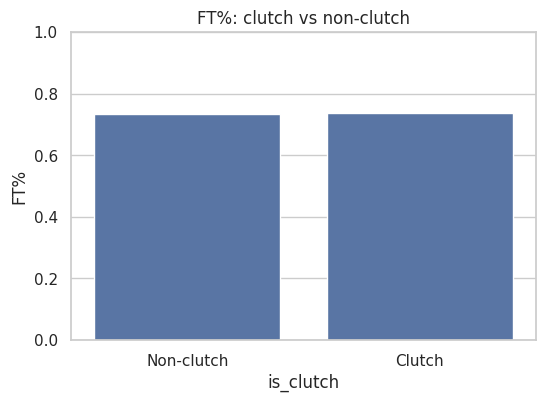

,is_clutch,FT_made
0,0,0.735128
1,1,0.737378


In [ ]:
# EDA 1: FT% in clutch vs non-clutch situations
eda_df = model_df.copy()

clutch_ft = eda_df.groupby("is_clutch")["FT_made"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=clutch_ft, x="is_clutch", y="FT_made")
plt.xticks([0,1], ["Non‑clutch", "Clutch"])
plt.ylabel("FT%")
plt.ylim(0,1)
plt.title("FT%: clutch vs non‑clutch")
plt.show()

clutch_ft

### EDA: FT% by period

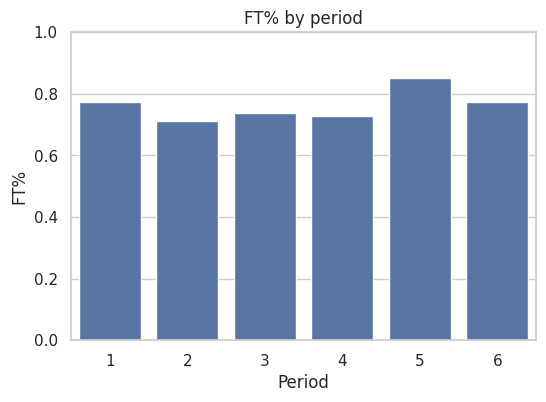

,period,FT_made
0,1,0.772612
1,2,0.711481
2,3,0.736587
3,4,0.728917
4,5,0.852941
5,6,0.772727


In [ ]:
# EDA 2: FT% by period
period_ft = eda_df.groupby("period")["FT_made"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=period_ft, x="period", y="FT_made")
plt.ylabel("FT%")
plt.xlabel("Period")
plt.ylim(0,1)
plt.title("FT% by period")
plt.show()

period_ft


### EDA: skill tiers

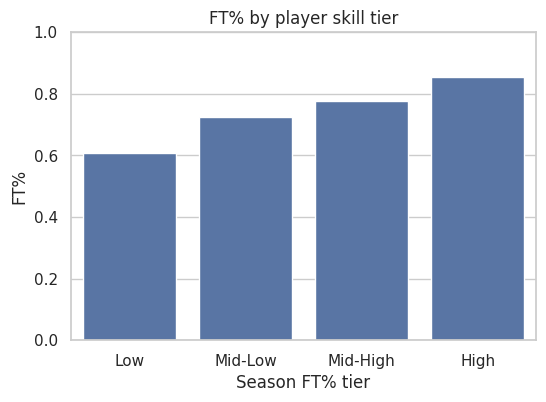

,skill_bucket,FT_made
0,Low,0.608547
1,Mid‑Low,0.726255
2,Mid‑High,0.777549
3,High,0.856307


In [ ]:
# EDA 3: FT% by player skill tier which is characterized by season FT%
df_skill = eda_df.dropna(subset=["season_FT_pct"]).copy()
df_skill["skill_bucket"] = pd.qcut(
    df_skill["season_FT_pct"],
    q=4,
    labels=["Low", "Mid‑Low", "Mid‑High", "High"]
)

skill_ft = (
    df_skill.groupby("skill_bucket", observed=True)["FT_made"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(6,4))
sns.barplot(data=skill_ft, x="skill_bucket", y="FT_made")
plt.xlabel("Season FT% tier")
plt.ylabel("FT%")
plt.ylim(0,1)
plt.title("FT% by player skill tier")
plt.show()

skill_ft


### EDA: Pressure Score

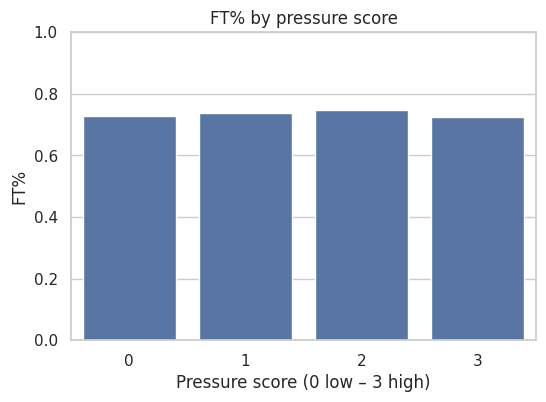

,pressure_score,FT_made
0,0,0.729647
1,1,0.738067
2,2,0.747448
3,3,0.724359


In [ ]:
# EDA 4: FT% by pressure score(higher means more pressure)
pressure_perf = (
    eda_df.groupby("pressure_score")["FT_made"]
    .mean()
    .reset_index()
    .sort_values("pressure_score")
)

plt.figure(figsize=(6,4))
sns.barplot(data=pressure_perf, x="pressure_score", y="FT_made")
plt.xlabel("Pressure score (0 low – 3 high)")
plt.ylabel("FT%")
plt.ylim(0,1)
plt.title("FT% by pressure score")
plt.show()

pressure_perf


### Train-Test Split and Preprocessing

In [ ]:
# Create chronological train-test split and preprocess(imput and scale)
X = model_df[FEATURE_COLS].copy()
y = model_df["FT_made"].astype(int).copy()
game_ids = model_df["game_id"].unique()

train_games, test_games = train_test_split(
    game_ids, test_size=0.2, shuffle=False
)
train_mask = model_df["game_id"].isin(train_games)
test_mask = model_df["game_id"].isin(test_games)

X_train_raw = X[train_mask].copy()
X_test_raw = X[test_mask].copy()
y_train = y[train_mask].copy()
y_test = y[test_mask].copy()

imputer = SimpleImputer(strategy="median")
X_train_imp = pd.DataFrame(
    imputer.fit_transform(X_train_raw),
    columns=FEATURE_COLS,
    index=X_train_raw.index,
)
X_test_imp = pd.DataFrame(
    imputer.transform(X_test_raw),
    columns=FEATURE_COLS,
    index=X_test_raw.index,
)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_imp),
    columns=FEATURE_COLS,
    index=X_train_imp.index,
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imp),
    columns=FEATURE_COLS,
    index=X_test_imp.index,
)

X_train_scaled.to_csv("X_train.csv", index=False)
X_test_scaled.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

X_train_scaled.shape, X_test_scaled.shape

((9093, 12), (2192, 12))

In [ ]:
# Create internal train/validation split from training set for Optuna tuning

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, stratify=y_train, random_state=42
)

X_tr.shape, X_val.shape

((7274, 12), (1819, 12))

### Optuna Objectives for 3 models

In [ ]:
# Define Optuna objective functions for Logistic Regression, Random Forest, XGBoost
# Optimize PR-AUC (average_precision_score)
def logreg_objective(trial):
    params = {
      "C": trial.suggest_float("C", 1e-3, 100.0, log=True),
      "penalty": "l2",
      "solver": trial.suggest_categorical("solver", ["lbfgs", "liblinear"]),
      "max_iter": trial.suggest_int("max_iter", 200, 1000),
      'random_state': 42
  }
    model = LogisticRegression(**params)
    model.fit(X_tr, y_tr)
    y_proba = model.predict_proba(X_val)[:, 1]
    return average_precision_score(y_val, y_proba)


def rf_objective(trial):
    params = {
      'n_estimators': trial.suggest_int('n_estimators', 100, 600),
      'max_depth': trial.suggest_int('max_depth', 2, 20),
      'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
      'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
      'random_state': 42
      }
    model = RandomForestClassifier(**params)
    model.fit(X_tr, y_tr)
    y_proba = model.predict_proba(X_val)[:, 1]
    return average_precision_score(y_val, y_proba)


def xgb_objective(trial):
    params = {
      'n_estimators': trial.suggest_int('n_estimators', 100, 600),
      'max_depth': trial.suggest_int('max_depth', 2, 20),
      'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
      'subsample': trial.suggest_float('subsample', 0.5, 1.0),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
      'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
      'objective': 'binary:logistic',
      'eval_metric': 'logloss',
      'random_state': 42
      }
    model = XGBClassifier(**params)
    model.fit(X_tr, y_tr)
    y_proba = model.predict_proba(X_val)[:, 1]
    return average_precision_score(y_val, y_proba)


### Run Optuma Studies

In [ ]:
# Run Optuna: ~30 trials per model, optimize PR-AUC

optuna.logging.set_verbosity(optuna.logging.WARNING)

study_logreg = optuna.create_study(direction="maximize", study_name="logreg_pr_auc")
study_logreg.optimize(logreg_objective, n_trials=30)

study_rf = optuna.create_study(direction="maximize", study_name="rf_pr_auc")
study_rf.optimize(rf_objective, n_trials=30)

study_xgb = optuna.create_study(direction="maximize", study_name="xgb_pr_auc")
study_xgb.optimize(xgb_objective, n_trials=30)

print("Best LogReg PR-AUC:", study_logreg.best_value)
print("Best LogReg params:", study_logreg.best_params)
print("Best RF PR-AUC:", study_rf.best_value)
print("Best RF params:", study_rf.best_params)
print("Best XGB PR-AUC:", study_xgb.best_value)
print("Best XGB params:", study_xgb.best_params)

### Choose winning model and retrain on full training set

In [ ]:
# Identify best model by PR-AUC and retrain on full training data

best_scores = {
    "logreg": study_logreg.best_value,
    "rf": study_rf.best_value,
    "xgb": study_xgb.best_value,
}
best_model_name = max(best_scores, key=best_scores.get)
print("Winning model:", best_model_name)

if best_model_name == "logreg":
    params = study_logreg.best_params
    final_model = LogisticRegression(
        C=params["C"],
        solver=params["solver"],
        max_iter=params["max_iter"],
        random_state=42,
        n_jobs=-1 if params["solver"] == "lbfgs" else None,
    )
elif best_model_name == "rf":
    params = study_rf.best_params
    final_model = RandomForestClassifier(
        **params,
        random_state=42,
        n_jobs=-1,
    )
else:
    params = study_xgb.best_params
    final_model = XGBClassifier(
        **params,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
    )

final_model.fit(X_train_scaled, y_train)

Winning model: xgb


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6464992635549422, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01673591028392758,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=216, n_jobs=-1,
              num_parallel_tree=None, ...)

### Test-set evaluation and visualizations

=== Test performance XGB ===
Accuracy   : 0.7518
PR-AUC     : 0.8378
Brier score: 0.1773
ROC-AUC    : 0.6425


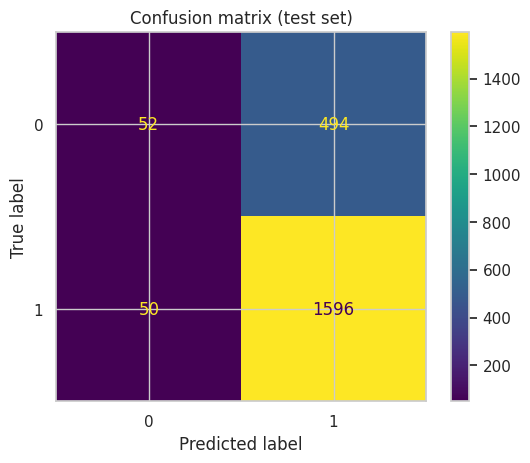

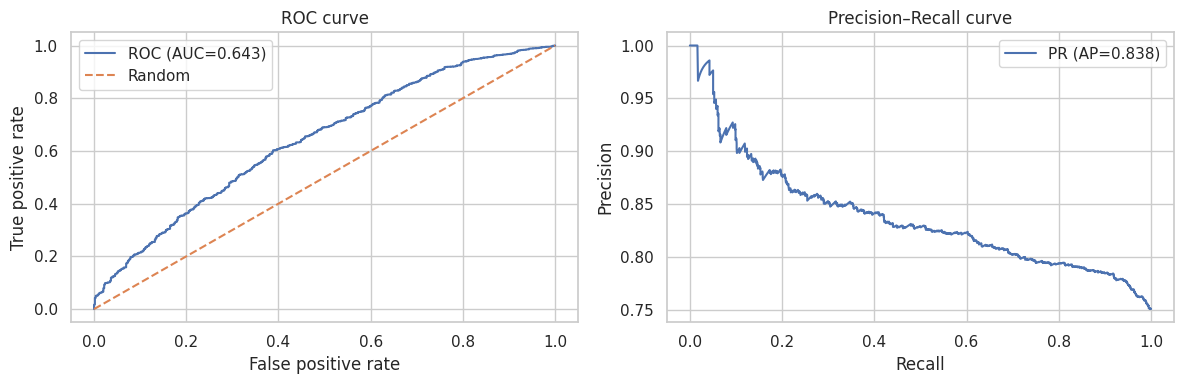

In [ ]:
# Evaluate winning model on test set and visualize metrics

y_proba_test = final_model.predict_proba(X_test_scaled)[:, 1]
y_pred_test = (y_proba_test >= 0.5).astype(int)

test_acc = accuracy_score(y_test, y_pred_test)
test_pr_auc = average_precision_score(y_test, y_proba_test)
test_brier = brier_score_loss(y_test, y_proba_test)
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
roc_auc_val = auc(fpr, tpr)

print(f"=== Test performance {best_model_name.upper()} ===")
print(f"Accuracy   : {test_acc:.4f}")
print(f"PR-AUC     : {test_pr_auc:.4f}")
print(f"Brier score: {test_brier:.4f}")
print(f"ROC-AUC    : {roc_auc_val:.4f}")

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot(values_format="d")
plt.title("Confusion matrix (test set)")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_proba_test)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc_val:.3f})")
plt.plot([0,1],[0,1],"--",label="Random")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(recall, precision, label=f"PR (AP={test_pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve")
plt.legend()

plt.tight_layout()
plt.show()

### Feature Importance Ranking

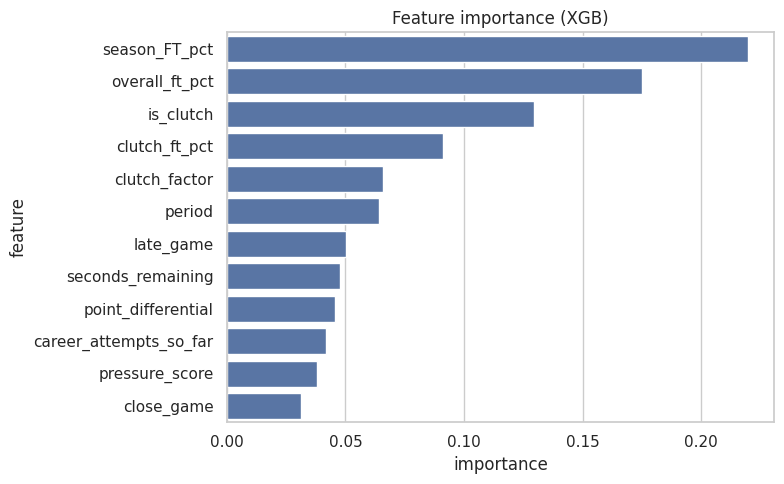

In [ ]:
# Show feature importances (for tree-based winning model)

if hasattr(final_model, "feature_importances_"):
    importances = final_model.feature_importances_
    feat_imp = (
        pd.DataFrame({"feature": FEATURE_COLS, "importance": importances})
        .sort_values("importance", ascending=False)
    )
    plt.figure(figsize=(8,5))
    sns.barplot(data=feat_imp, x="importance", y="feature")
    plt.title(f"Feature importance ({best_model_name.upper()})")
    plt.tight_layout()
    plt.show()

    feat_imp
else:
    print("Final model does not expose feature_importances_.")

### Save Winning Model

In [ ]:
# Save winning model and preprocessors for reuse

with open("final_model.pkl", "wb") as f:
    pickle.dump(final_model, f)
with open("imputer.pkl", "wb") as f:
    pickle.dump(imputer, f)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Saved final_model.pkl, imputer.pkl, scaler.pkl")

Saved final_model.pkl, imputer.pkl, scaler.pkl


### Use Module for Deployment-style training and prediction

In [ ]:
# Create a function to train and save model(already in module therefore this is just for reference)
def train_and_save_model_notebook(
    play_by_play_path: str,
    nrows: Optional[int] = None,
    test_size: float = 0.2,
    model_path: str = "final_rf.pkl",
    imputer_path: str = "imputer.pkl",
    scaler_path: str = "scaler.pkl",
    x_test_path: str = "X_test_raw.csv",
    y_test_path: str = "y_test.csv",
) -> Dict[str, float]:
    """
    End-to-end training from play_by_play CSV.

    - Game-level train/test split (no leakage)
    - Impute + scale features
    - Train RandomForest with BEST_RF_PARAMS (OOB enabled)
    - Save model, imputer, scaler, and raw test set (for later evaluation)

    Returns
    -------
    metrics : dict
        {'accuracy', 'pr_auc', 'brier', 'oob_score'}
    """
    raw_df = pd.read_csv(play_by_play_path, nrows=nrows)
    model_df = prepare_ft_dataset_from_df(raw_df)

    X = model_df[FEATURE_COLS].copy()
    y = model_df["FT_made"].astype(int).copy()
    game_ids = model_df["game_id"].unique()

    # Game-level split
    train_games, test_games = train_test_split(
        game_ids, test_size=test_size, shuffle=False
    )
    train_mask = model_df["game_id"].isin(train_games)
    test_mask = model_df["game_id"].isin(test_games)

    X_train_raw = X[train_mask].copy()
    X_test_raw = X[test_mask].copy()
    y_train = y[train_mask].copy()
    y_test = y[test_mask].copy()

    # Impute + scale
    imputer = SimpleImputer(strategy="median")
    X_train_imp = pd.DataFrame(
        imputer.fit_transform(X_train_raw),
        columns=FEATURE_COLS,
        index=X_train_raw.index,
    )
    X_test_imp = pd.DataFrame(
        imputer.transform(X_test_raw),
        columns=FEATURE_COLS,
        index=X_test_raw.index,
    )

    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_imp),
        columns=FEATURE_COLS,
        index=X_train_imp.index,
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test_imp),
        columns=FEATURE_COLS,
        index=X_test_imp.index,
    )

    # Model with OOB
    model = RandomForestClassifier(**BEST_RF_PARAMS)
    model.fit(X_train_scaled, y_train)

    # Test metrics
    y_proba_test = model.predict_proba(X_test_scaled)[:, 1]
    y_pred_test = (y_proba_test >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred_test)
    pr_auc = average_precision_score(y_test, y_proba_test)
    brier = brier_score_loss(y_test, y_proba_test)
    oob = float(model.oob_score_)

    # Save artifacts
    X_test_raw.to_csv(x_test_path, index=False)
    y_test.to_csv(y_test_path, index=False)

    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    with open(imputer_path, "wb") as f:
        pickle.dump(imputer, f)
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)

    metrics = {
        "accuracy": float(acc),
        "pr_auc": float(pr_auc),
        "brier": float(brier),
        "oob_score": oob,
    }
    return metrics

In [ ]:
import importlib
import ft_pressure_final
importlib.reload(ft_pressure_final)

from ft_pressure_final import (
    prepare_ft_dataset_from_df,
    train_and_save_model,
    FTPressurePredictor,
    evaluate_model,
    FEATURE_COLS,
)

# Decide which *tree-based* model to deploy (ignore logreg here)
tree_scores = {
    "rf": study_rf.best_value,
    "xgb": study_xgb.best_value,
}
best_tree_model = max(tree_scores, key=tree_scores.get)
print("Best tree model for deployment:", best_tree_model)

model_path = f"final_{best_tree_model}.pkl"
# Train final deployed model using the module
metrics = train_and_save_model(
    play_by_play_path=play_by_play_path,
    nrows=100000,
    test_size=0.2,
    model_type=best_tree_model,
    model_path=model_path,
)
print("Deployed model metrics:", metrics)

# Load predictor and test data
predictor = FTPressurePredictor()
X_test_mod = pd.read_csv("X_test.csv")
y_test_mod = pd.read_csv("y_test.csv").iloc[:, 0]

# Evaluate via module helper
eval_metrics = evaluate_model(predictor, X_test_mod, y_test_mod)
print("Evaluation metrics:", eval_metrics)

Example: Single shot and Batch Predictions

In [ ]:
example_shot = {
    "season_FT_pct": 0.80,
    "overall_ft_pct": 0.78,
    "clutch_ft_pct": 0.85,
    "clutch_factor": 0.07,
    "career_attempts_so_far": 100,
    "period": 4,
    "seconds_remaining": 45,
    "is_clutch": 1,
    "close_game": 1,
    "late_game": 1,
    "pressure_score": 3,
    "point_differential": 2,
}

exp = predictor.predict_single_with_explanation(example_shot)
print("P(make):", exp.prob_make)
print("Predicted label:", exp.predicted_label)
print("Top factors:")
for f in exp.top_factors:
    print(f)


P(make): 0.8361873626708984
Predicted label: 1
Top factors:
{'feature': 'is_clutch', 'value': 2.018469407744393, 'contribution_pct': 36.83721619223477}
{'feature': 'late_game', 'value': 1.4318933916339693, 'contribution_pct': 12.56141295337281}
{'feature': 'season_FT_pct', 'value': 0.5829577750926249, 'contribution_pct': 10.952390537060127}
